# Introduction
Customer churn, also known as customer attrition, is a critical challenge faced by businesses across various industries, including the banking sector. Churn occurs when customers discontinue their relationship with a company, whether by closing accounts, discontinuing services, or switching to competitors.

Churn prediction involves identifying customers who are at risk of churning based on their behavior, transaction history, demographics, and other relevant factors. By leveraging data analytics and machine learning techniques, banks can proactively address customer dissatisfaction, personalize retention strategies, and improve customer loyalty.

In this Jupyter Notebook, we will explore a churn prediction problem.<br>
Note : This is randomly generated data due to customers privacy and this is not a real data, Since you can discover by:
1. Names Are Strange And Does Not Represent Actual Human Names
2. Balance Is Repeated With The Same Decimal Points For Different Customers
3. EstimatedSalary Also Is Repeated With The Same Decimal Points For Different Customers
- So We Just Show How To Work With The Process Of EDA & ML.




# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
sns.set_palette('viridis')
import missingno as ms
from tqdm.auto import tqdm
from time import time
#ML
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV,train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import joblib
import warnings
warnings.filterwarnings('ignore')

# Data Wrangling

In [2]:
train = pd.read_csv('Data/train.csv')
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
#Drop unnecessary columns
train.drop(columns=['id','CustomerId','Surname'],inplace=True)

<Axes: >

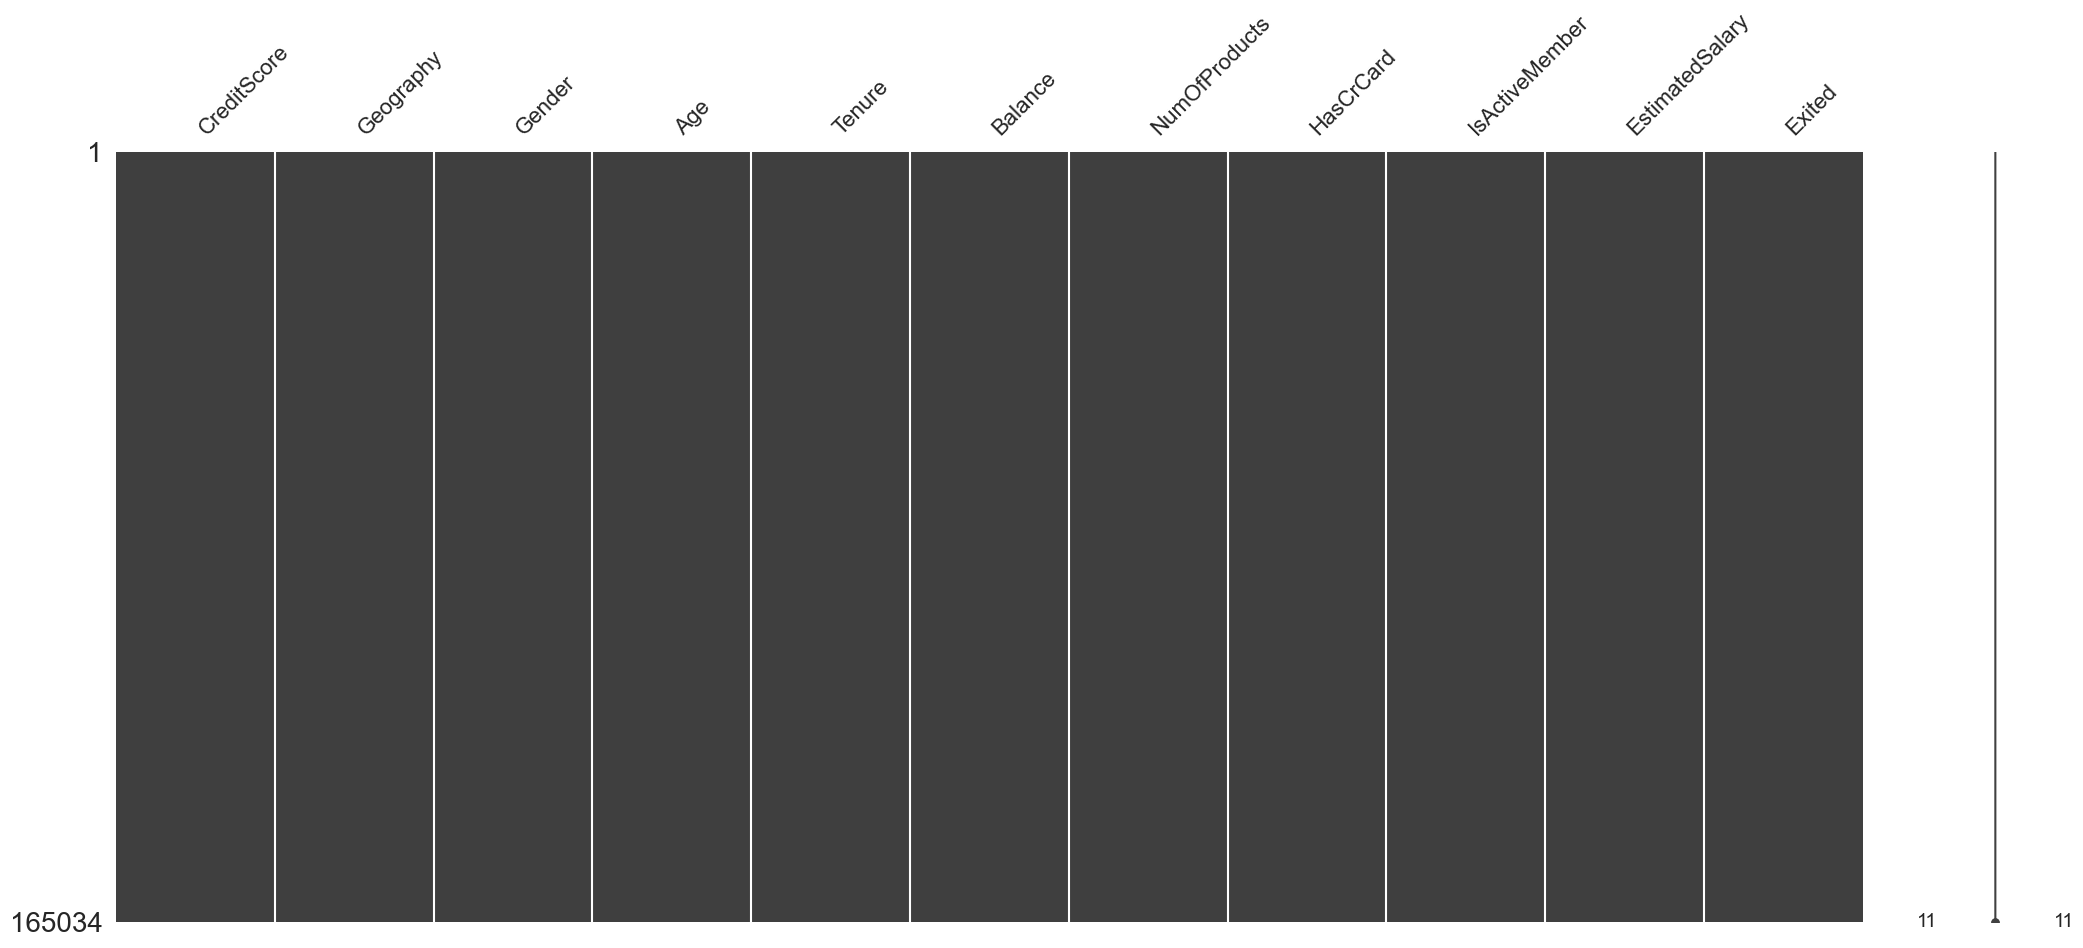

In [4]:
#Discover Nulls
ms.matrix(train)

In [5]:
#Discover Duplicates
train.duplicated().sum()

123

In [6]:
#Validating duplicates excistance
train[train.duplicated(keep=False)].sort_values('EstimatedSalary')

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
37390,730,France,Male,38.0,7,0.00,2,1.0,0.0,1528.40,0
97216,730,France,Male,38.0,7,0.00,2,1.0,0.0,1528.40,0
118222,514,France,Female,41.0,5,0.00,2,1.0,1.0,3756.65,0
139411,514,France,Female,41.0,5,0.00,2,1.0,1.0,3756.65,0
137561,459,Germany,Male,46.0,7,110356.42,1,1.0,1.0,4969.13,0
...,...,...,...,...,...,...,...,...,...,...,...
60434,572,Germany,Male,49.0,1,99353.42,1,1.0,0.0,196549.85,1
94677,699,France,Female,43.0,3,80764.03,1,1.0,0.0,199378.58,0
122964,699,France,Female,43.0,3,80764.03,1,1.0,0.0,199378.58,0
151774,700,Spain,Female,40.0,2,0.00,2,0.0,1.0,199753.97,0


In [7]:
#Drop duplicates
train.drop_duplicates(inplace=True)
train.reset_index(inplace=True,drop=True)

In [8]:
#Info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164911 entries, 0 to 164910
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      164911 non-null  int64  
 1   Geography        164911 non-null  object 
 2   Gender           164911 non-null  object 
 3   Age              164911 non-null  float64
 4   Tenure           164911 non-null  int64  
 5   Balance          164911 non-null  float64
 6   NumOfProducts    164911 non-null  int64  
 7   HasCrCard        164911 non-null  float64
 8   IsActiveMember   164911 non-null  float64
 9   EstimatedSalary  164911 non-null  float64
 10  Exited           164911 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 13.8+ MB


In [9]:
#Summary stats
train.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,164911.000000,164911.000000,164911.000000,164911.000000,164911.000000,164911.000000,164911.000000,164911.000000,164911.000000
mean,656.468914,38.124278,5.020599,55481.138955,1.554420,0.753916,0.497693,112579.798396,0.211684
std,80.091065,8.865020,2.806237,62819.233625,0.547171,0.430730,0.499996,50290.229424,0.408503
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74639.870000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,42.000000,7.000000,119948.090000,2.000000,1.000000,1.000000,155155.250000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [10]:
train.describe(include='object')

,Geography,Gender
count,164911,164911
unique,3,2
top,France,Male
freq,94132,93075


- CreditScores indicate a high variance between customers creditscores and no extreme values
- Balance feature indicate a high variance between customers balance in the bank also the median and mean indicate a huge number of outliers in customer balances since the median is 0 while the mean is much larger. we will discover more about this in EDA
- The salaries between customers also indicates a huge difference between them, we will divide them into categories later
- Age,Tenure,Num of products feature is normal 
- Our Data Has Many Customers From France
- Males Are Slightly More In Our Data Than Females

In [11]:
#no. of unique values
train.nunique()

CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

# EDA

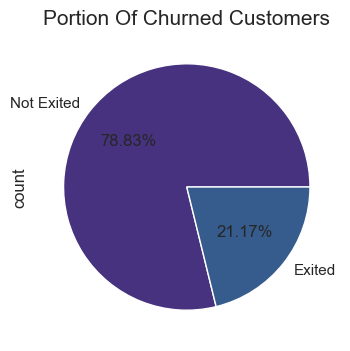

In [12]:
plt.figure(figsize=(4,4))
train['Exited'].value_counts().plot(kind='pie',autopct='%.2f%%',labels=['Not Exited','Exited'])
plt.title('Portion Of Churned Customers',size=15)
plt.show()

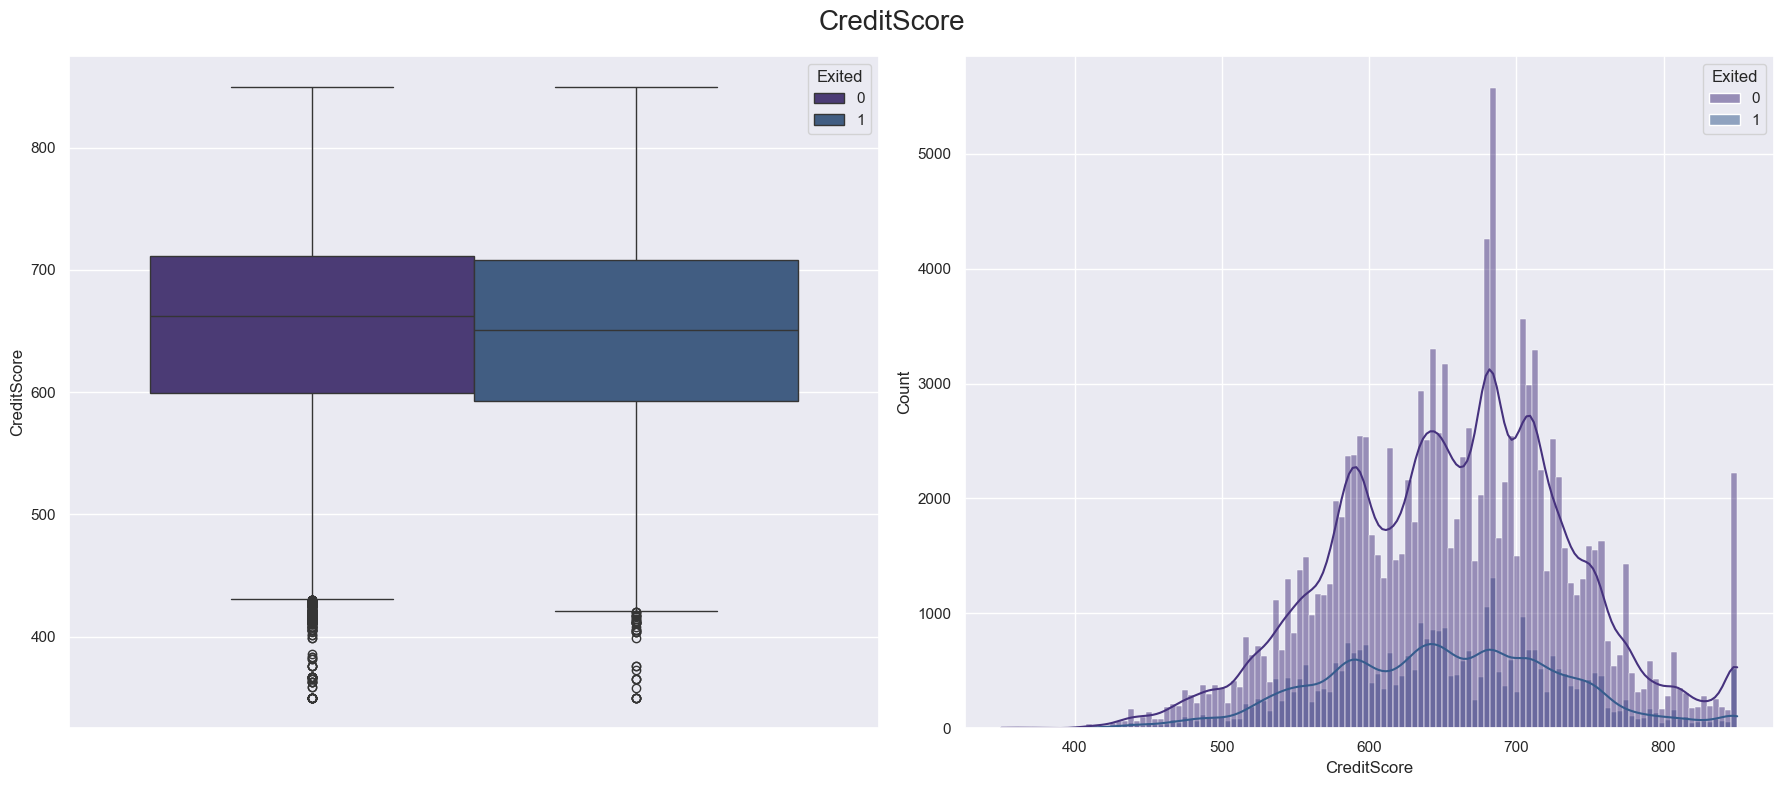

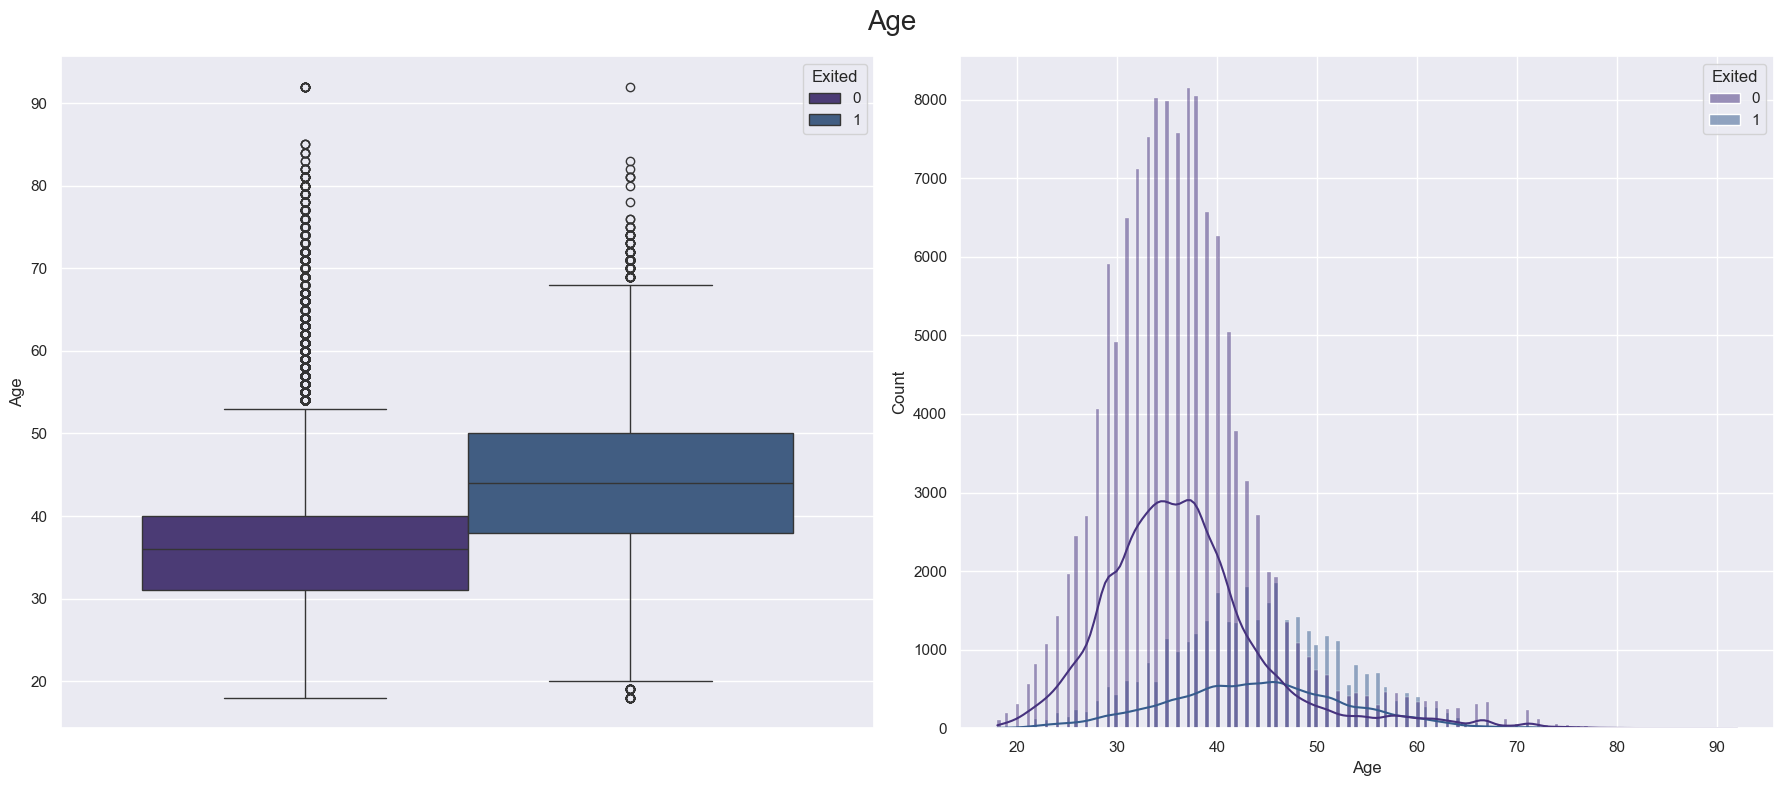

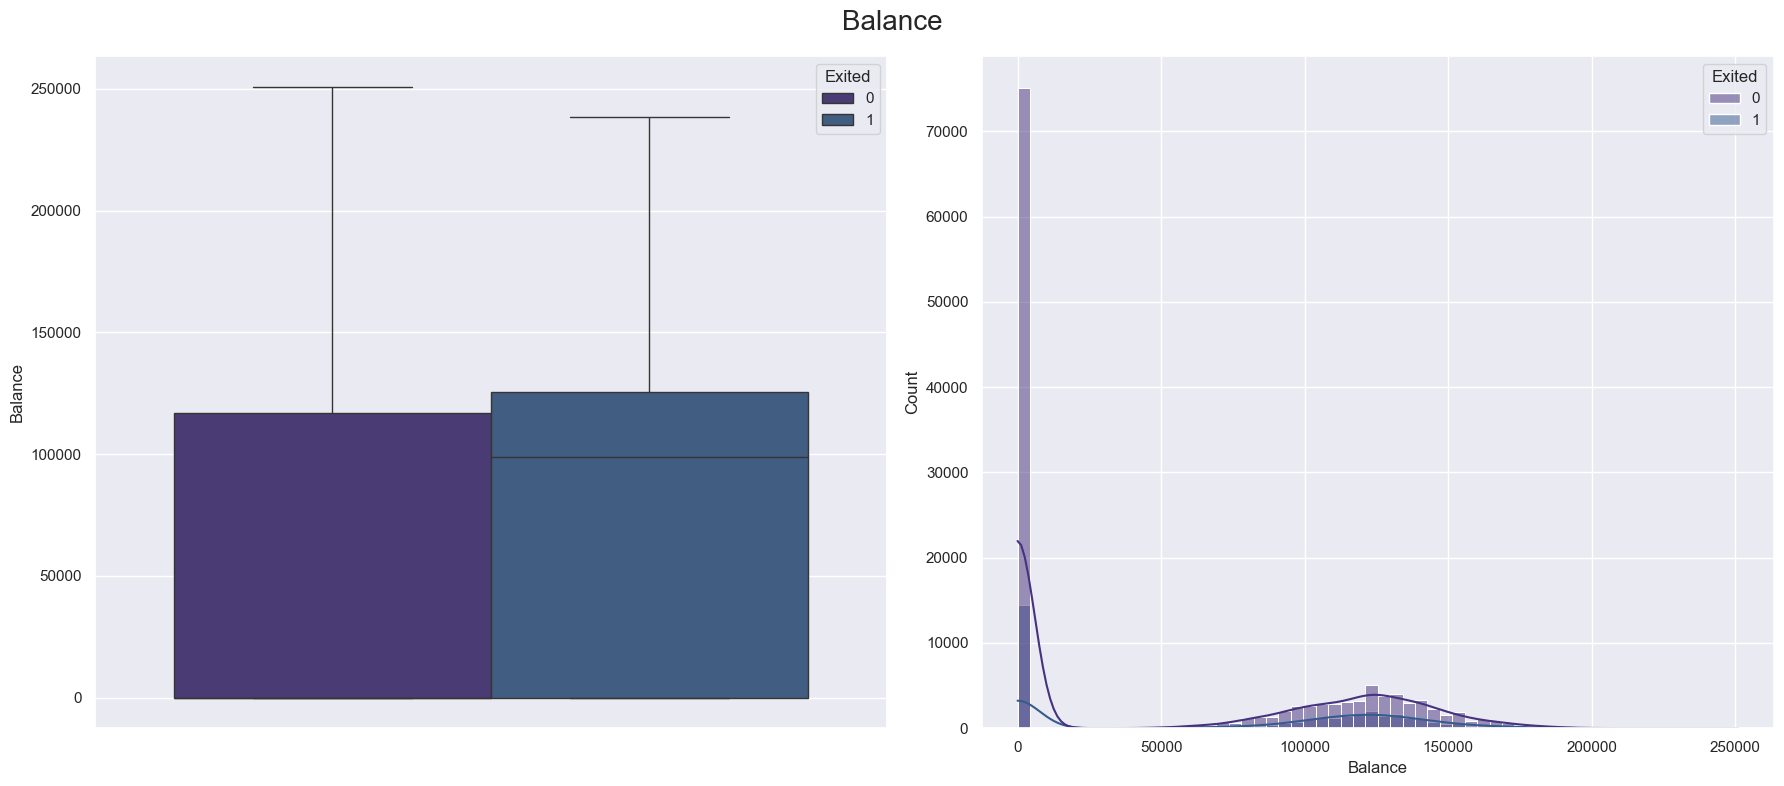

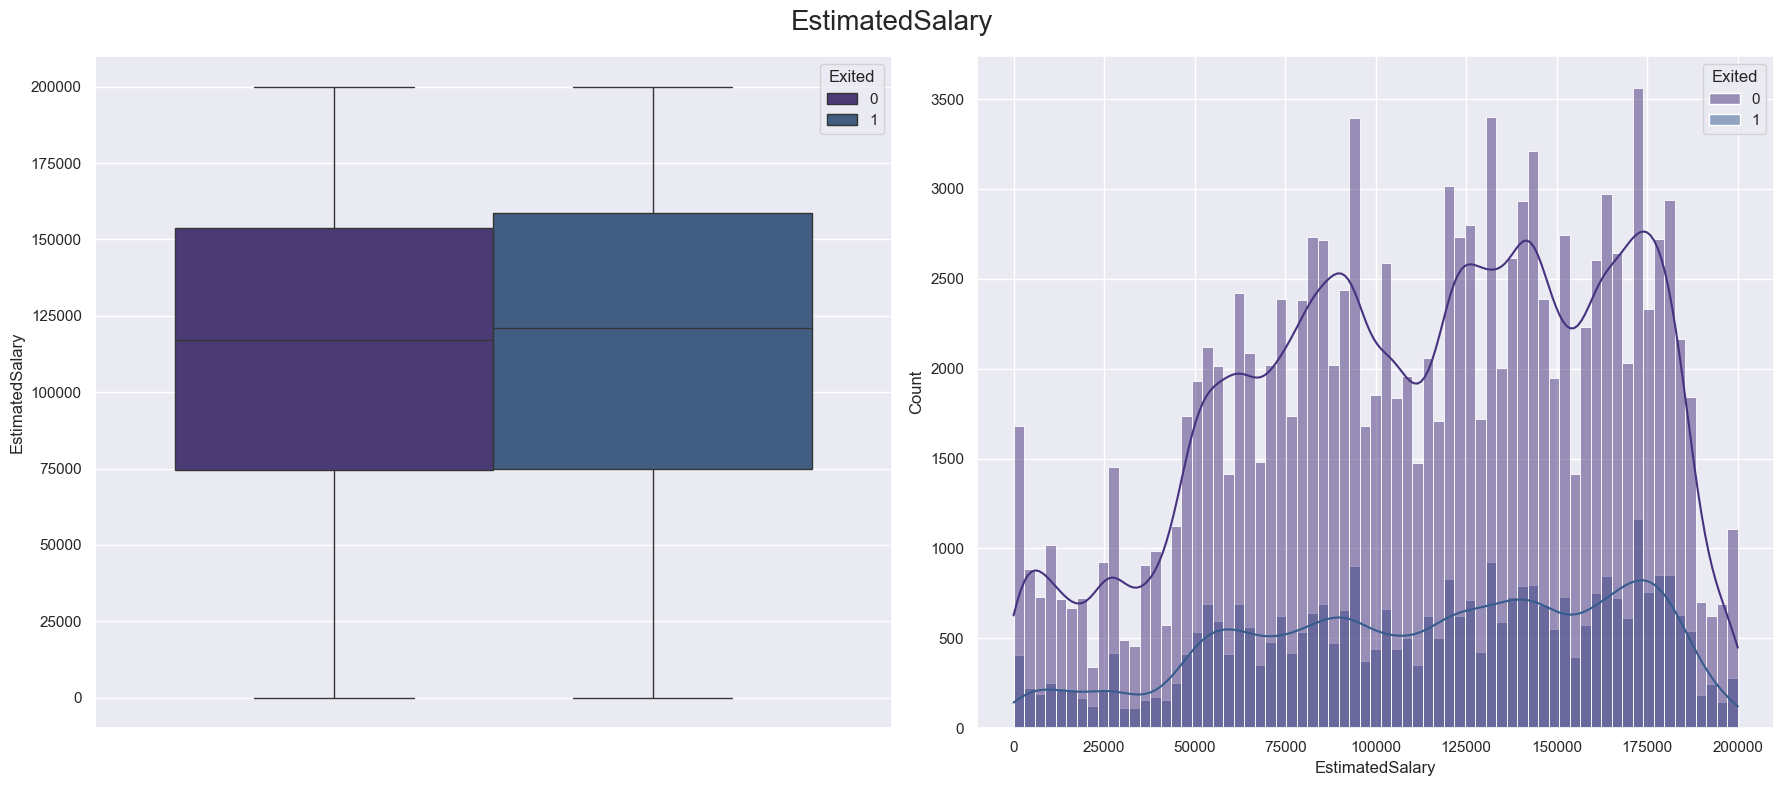

In [13]:
cols = ['CreditScore','Age','Balance','EstimatedSalary']
for col in cols:
    fig, axs = plt.subplots(1,2)
    fig.suptitle(col,size=20)
    sns.boxplot(data=train,y=col,ax=axs[0],hue='Exited')
    sns.histplot(data=train,x=col,ax=axs[1],hue='Exited',kde=True)
    fig.tight_layout()
    fig.show()

- Older ages are more likely to churn
- We discover many customers churned and not churned have no balance in the account 
- Estimated salary and Credit scores seems the same between churned and non churned, Let's apply hypothesis test to check.

In [14]:
def p_val_msg(p_val,alpha=0.05):
    if p_val < alpha:
        print('Null Hypothesis REJECTED, There Is Significant Difference Between The Two Means')
    else:
        print('Null Hypothesis ACCEPTED, There Is NO Significant Difference Between The Two Means')
    print('P_Value =',p_val)
def bootstraping(group1,group2,iterations=10000,alpha=0.05,method=np.mean):
    obs_diff = (group1.mean() - group2.mean())
    group1_means = []
    group2_means = []
    samples_diff = []
    size = max(len(group1),len(group2))
    for _ in tqdm(range(iterations),desc='Processing'):
        mu_1 = group1.sample(size,replace=True).mean()
        group1_means.append(mu_1)
        mu_2 = group2.sample(size,replace=True).mean()
        group2_means.append(mu_2)
        samples_diff.append(mu_1 - mu_2)
    group1_means,group2_means,samples_diff = np.array(group1_means),np.array(group2_means),np.array(samples_diff)
    del mu_1,mu_2
    samples_diff = samples_diff - np.mean(samples_diff) #shifting -> mu=0, Assumption of null hypothesis
    fig , axs = plt.subplots(1,2)
    #Plot 1 
    sns.distplot(samples_diff,bins=50,kde=True,ax=axs[0])
    #boundries of 95 % null distribution
    axs[0].axvline(np.quantile(samples_diff,alpha/2),c='r')
    axs[0].axvline(np.quantile(samples_diff,1-(alpha/2)),c='r')
    #observed_value
    axs[0].axvline(obs_diff,c='black')
    axs[0].set(title='Assumptions Under Null Hypothesis')
    axs[0].legend(labels=['H0 : Null Hypothesis'])
    #Plot 2
    sns.distplot(group1_means,bins=50,kde=True,ax=axs[1])
    sns.distplot(group2_means,bins=50,kde=True,ax=axs[1])
    axs[1].set(title='Sampling Means Between Two Samples')
    axs[1].legend(labels=['Group 1 Means','Group 2 Means'])
    fig.suptitle('Boostraping Hypothesis Testing',size=19)
    fig.tight_layout()
    fig.show()
    #P_val
    p_val = (np.abs(samples_diff)>=np.abs(obs_diff)).mean()
    return p_val_msg(p_val,alpha)

Testing EstimatedSalary


Processing:   0%|          | 0/10000 [00:00<?, ?it/s]

Null Hypothesis REJECTED, There Is Significant Difference Between The Two Means
P_Value = 0.0
------------------------------


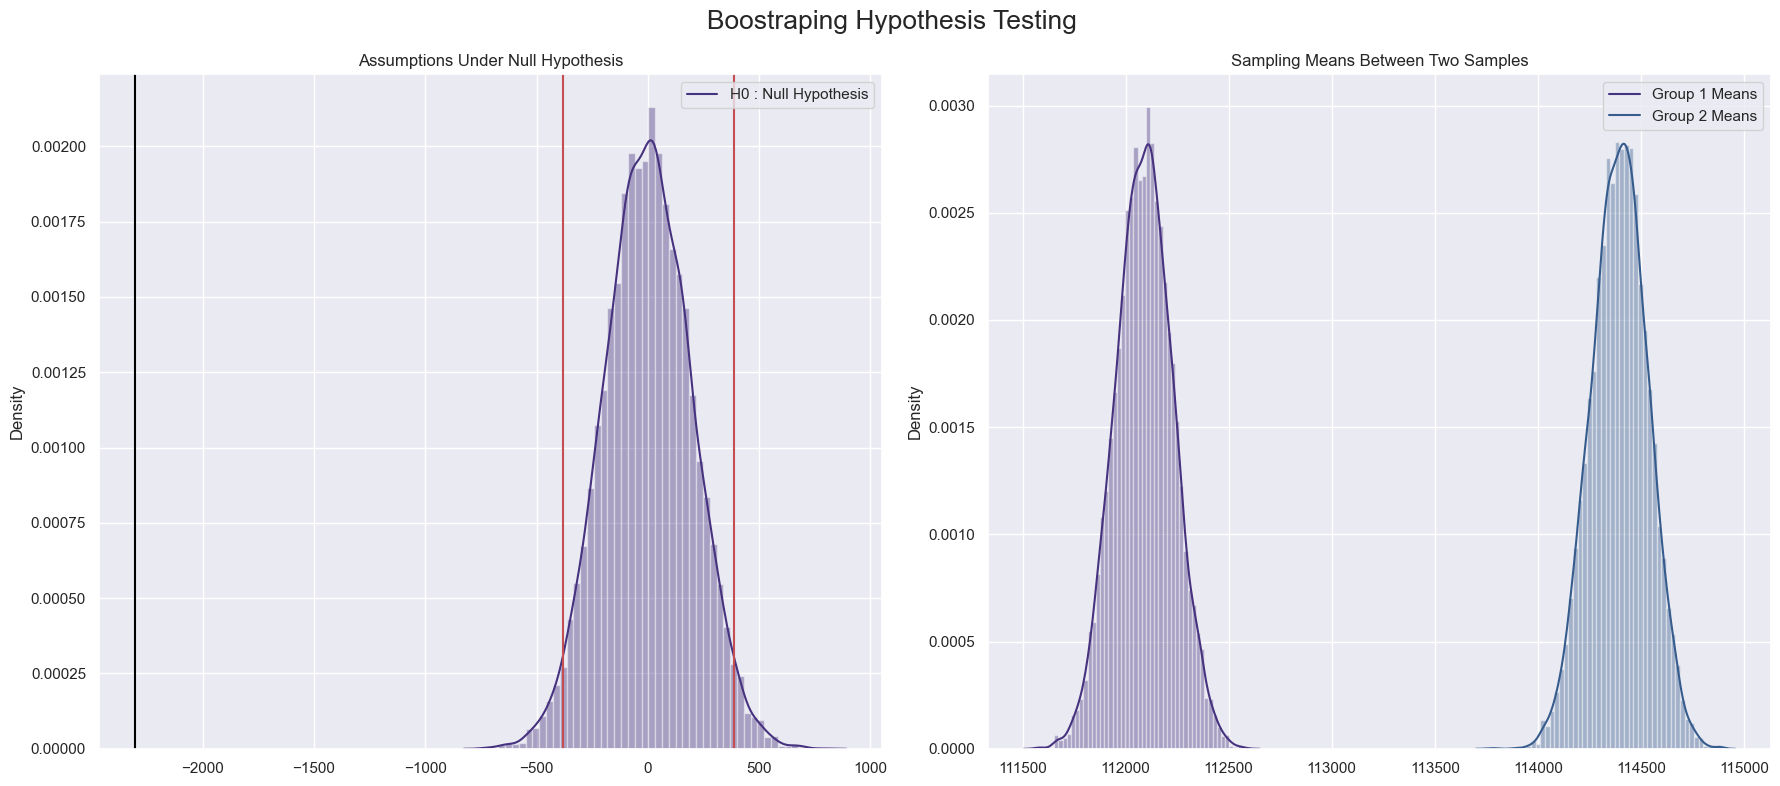

In [15]:
for col in ['EstimatedSalary','Balance']:
    print('Testing',col)
    bootstraping(
        train[train['Exited']==0][col],
        train[train['Exited']==1][col]
    )
    print('-'*30)

We strongly can reject the null hypothesis and there is a difference between the CreditScore and EstimatedSalary between churned customers and non churned customers

In [16]:
#Double check with Mann–Whitney U Test which is nonparametric test on two independent samples 
#(Doesn't give assumptions on the distribution of populations)
for col in ['EstimatedSalary','CreditScore']:
    p_val = mannwhitneyu(
    train[train['Exited']==0][col],
    train[train['Exited']==1][col],
    alternative='two-sided')[1]
    print(f'P_value = {p_val}')

P_value = 6.533471198231923e-16
P_value = 1.412957166268916e-32


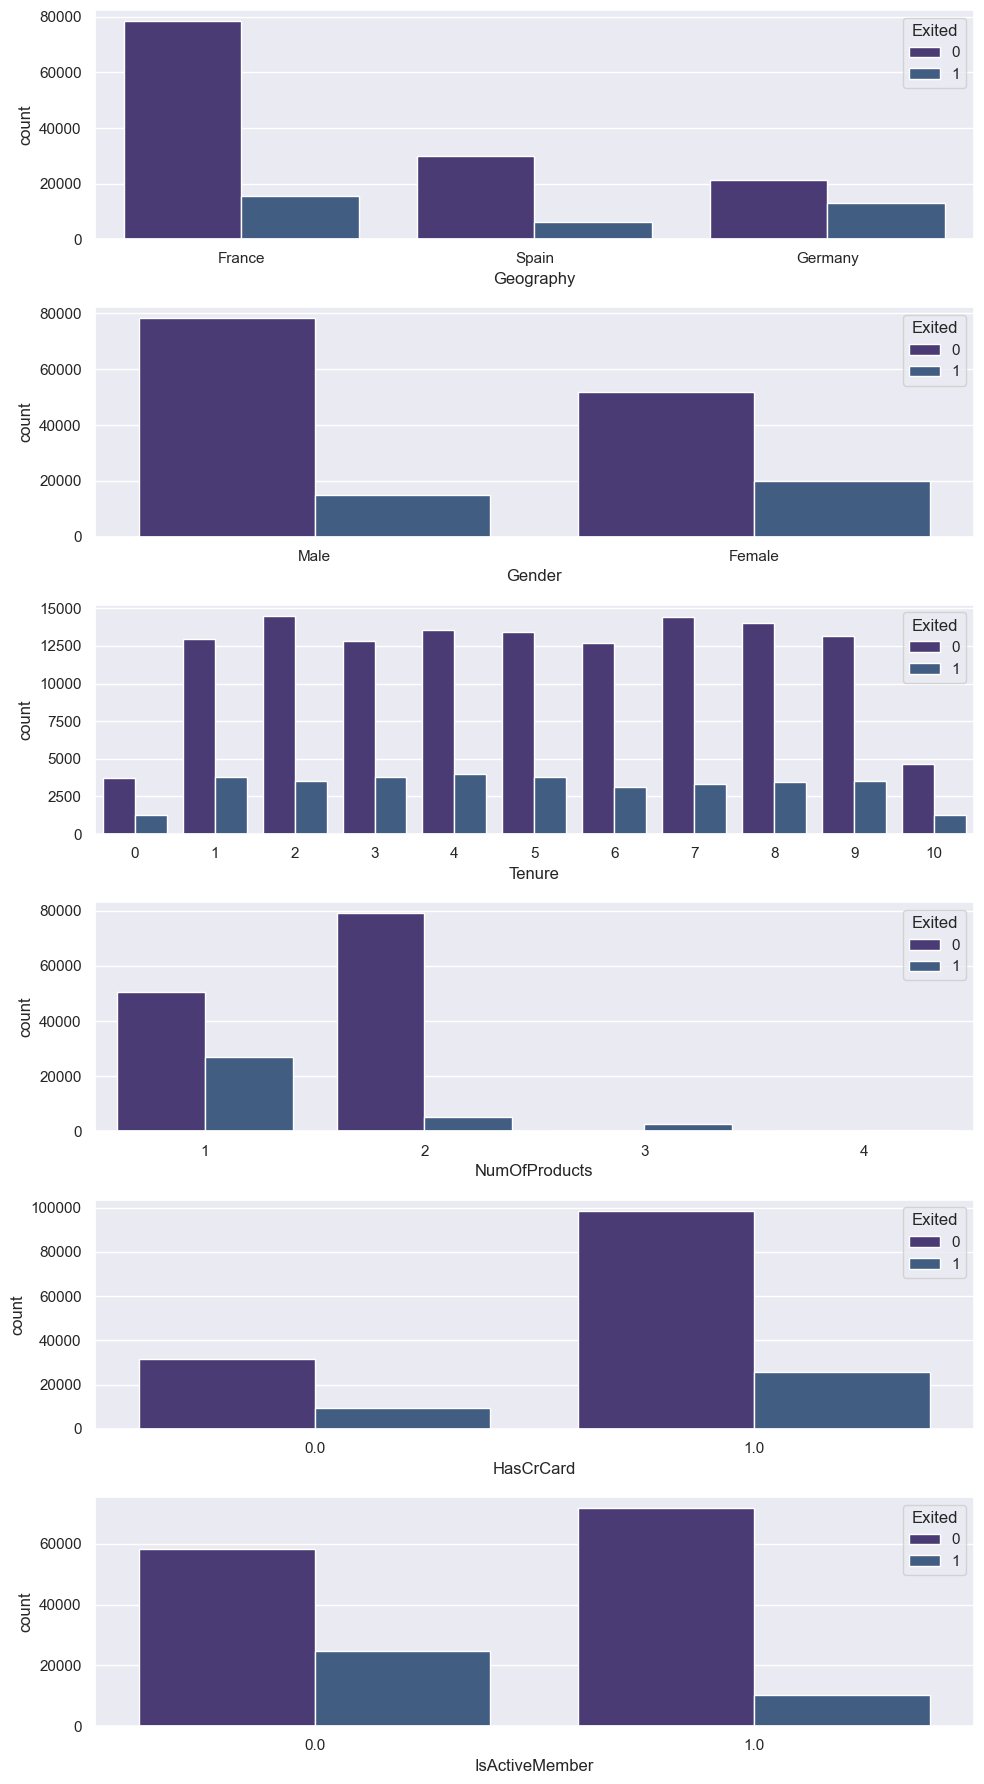

In [17]:
fig,axs = plt.subplots(6,1,figsize=(10,18))
cols = ['Geography','Gender','Tenure','NumOfProducts','HasCrCard','IsActiveMember']
for idx,col in enumerate(cols):
    sns.countplot(data=train,x=col,hue='Exited',ax=axs[idx])
fig.tight_layout()
fig.show()

- Most Of Data Is From France Customers And It Tends To Be That France Customers Are More Likely To Churn More Than Other Countries.
- Females Are Slightly Able To Churn More Than Males.
- From Tenure 1 ~ 5 , Customers Starts To Churn.
- Customers With 2 Product Are Less Likely To Churn Than Customers With 1 Product. (We Don't Have Enough Data About More Than 2 Products)
- Most Of Customers Holding CreditCards And Who Owns Are More Likely To Churn
- Non Active Customers Are More Likely To Churn.

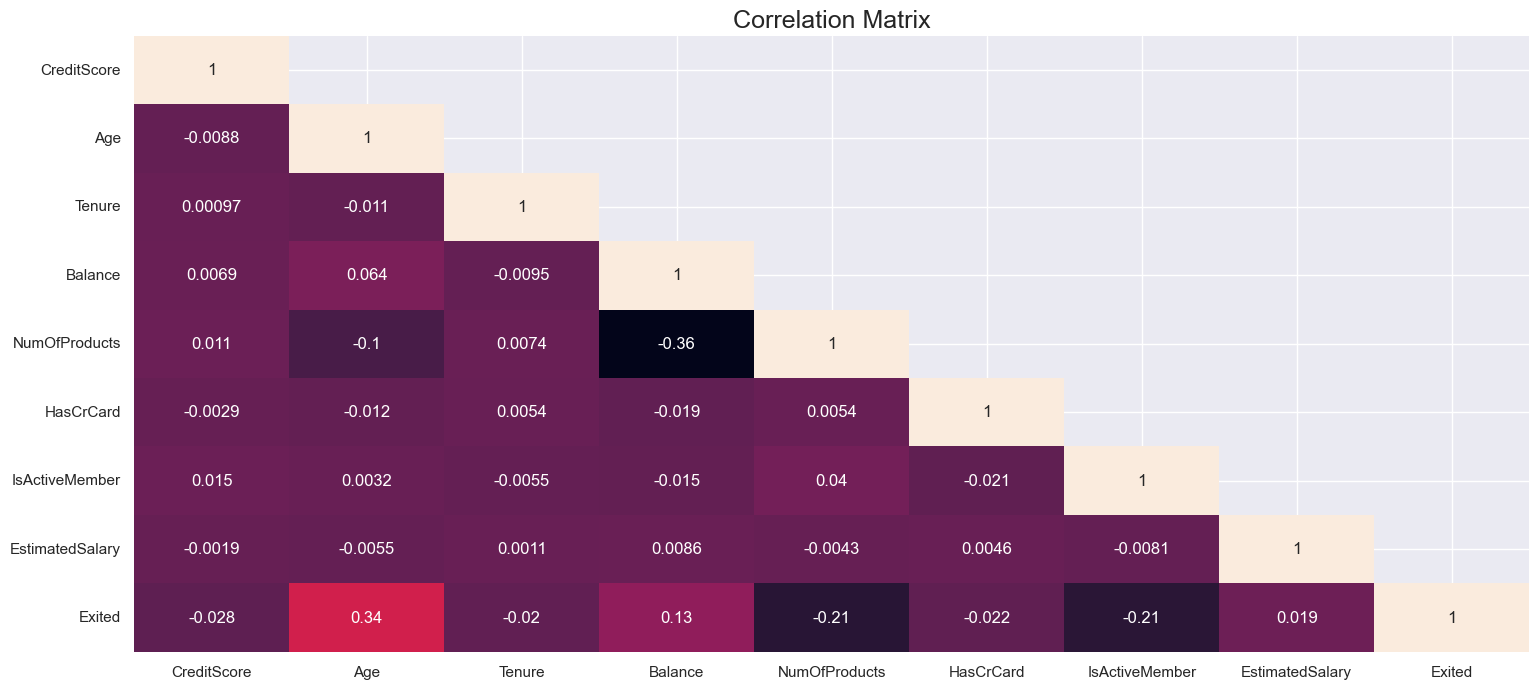

In [18]:
#Correlations
sns.heatmap(
    data=train.corr(numeric_only=True),
    annot=True,
    cbar=False,
    mask=np.triu(np.ones_like(train.corr(numeric_only=True)),k=1)
)
plt.title('Correlation Matrix',size=18)
plt.show()

There is no clear relation between features, Age has a weak positive correlation between the target as we have seen previously And Balance has a weak negative correlation between NumOfProducts

<Axes: xlabel='Geography', ylabel='CreditScore'>

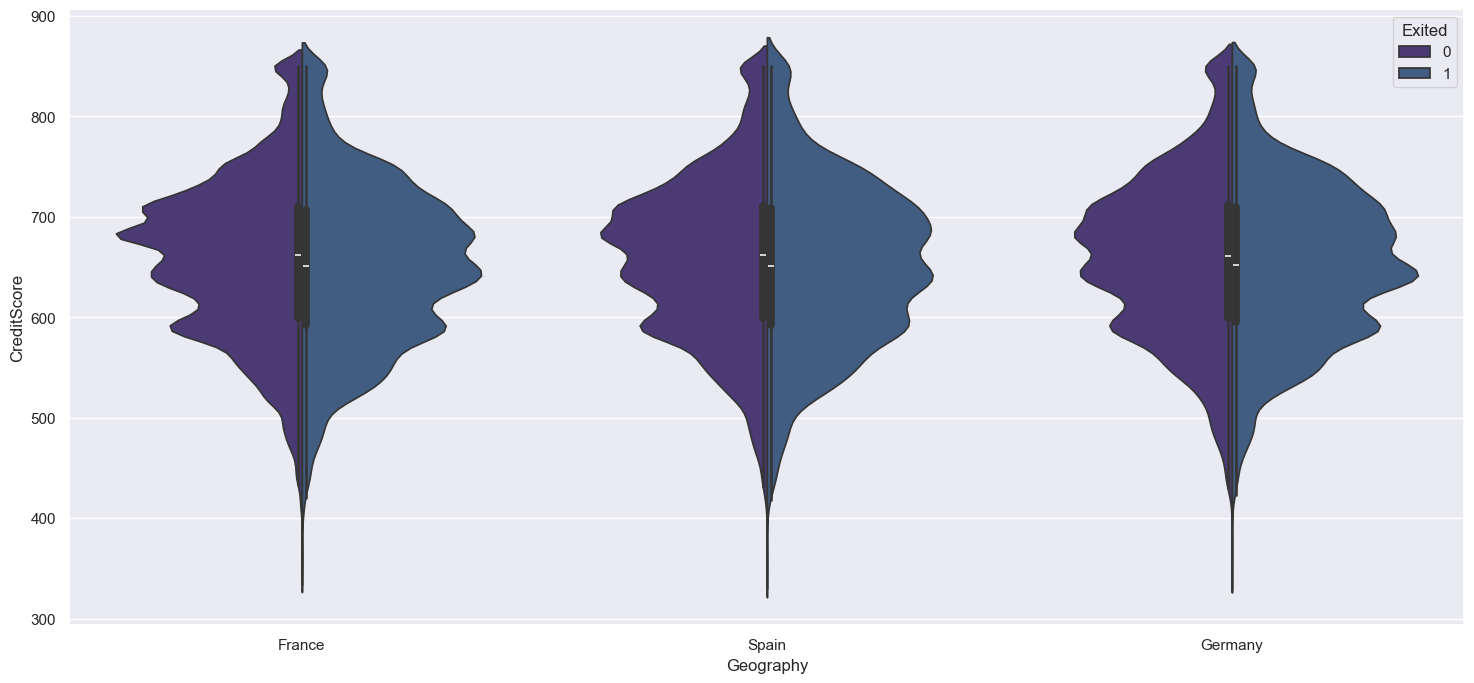

In [19]:
sns.violinplot(data=train,x='Geography',y='CreditScore',hue='Exited',split=True)

No Difference Between Credit Scores In Different Countries Between Churned And Non Churned Customers

<Axes: xlabel='Age', ylabel='CreditScore'>

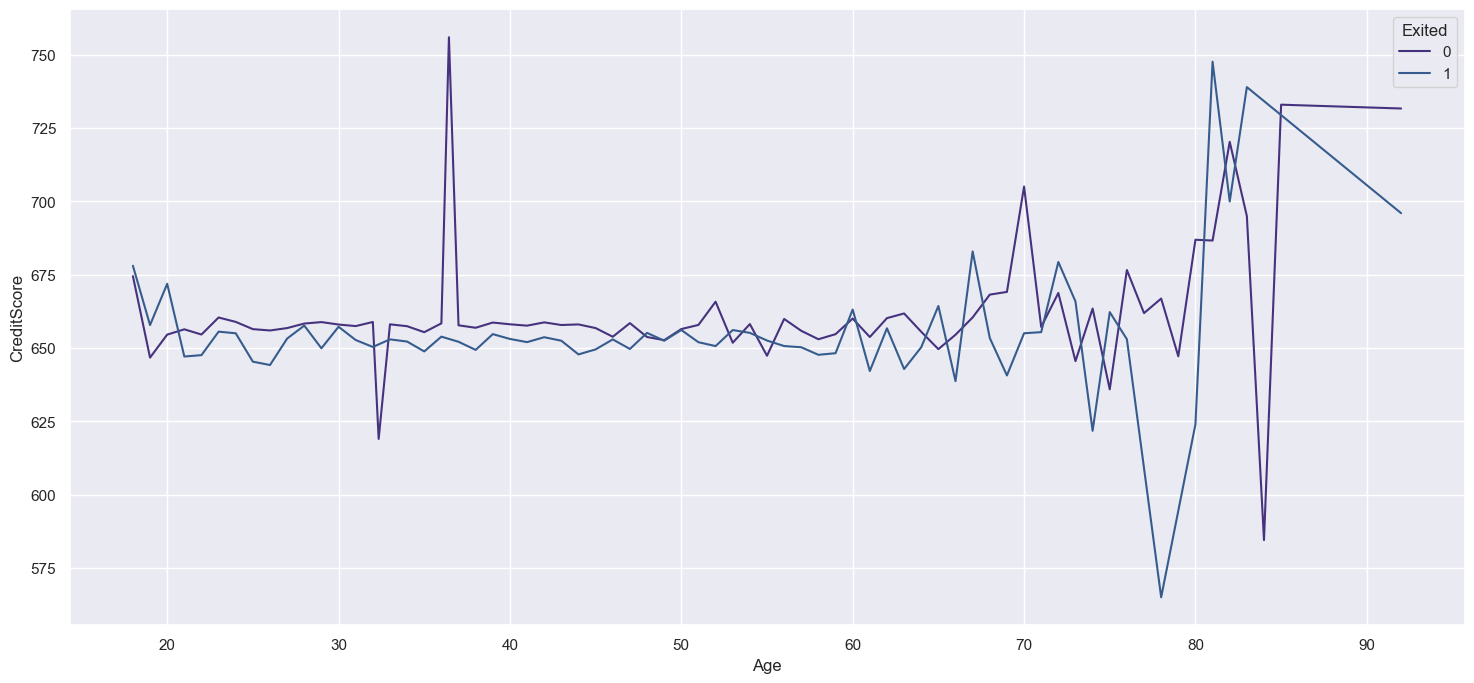

In [20]:
sns.lineplot(data=train,x='Age',y='CreditScore',hue='Exited',estimator=np.mean,ci=None)

- Ages From 18-20 Have Slightly Less CreditScore And More Likely To Churn
- Ages From 20-65 Have Slightly More CreditScore And Less Likely To Churn
- After Age 65, There Is No Clear Way To Decide

<Axes: xlabel='Tenure', ylabel='CreditScore'>

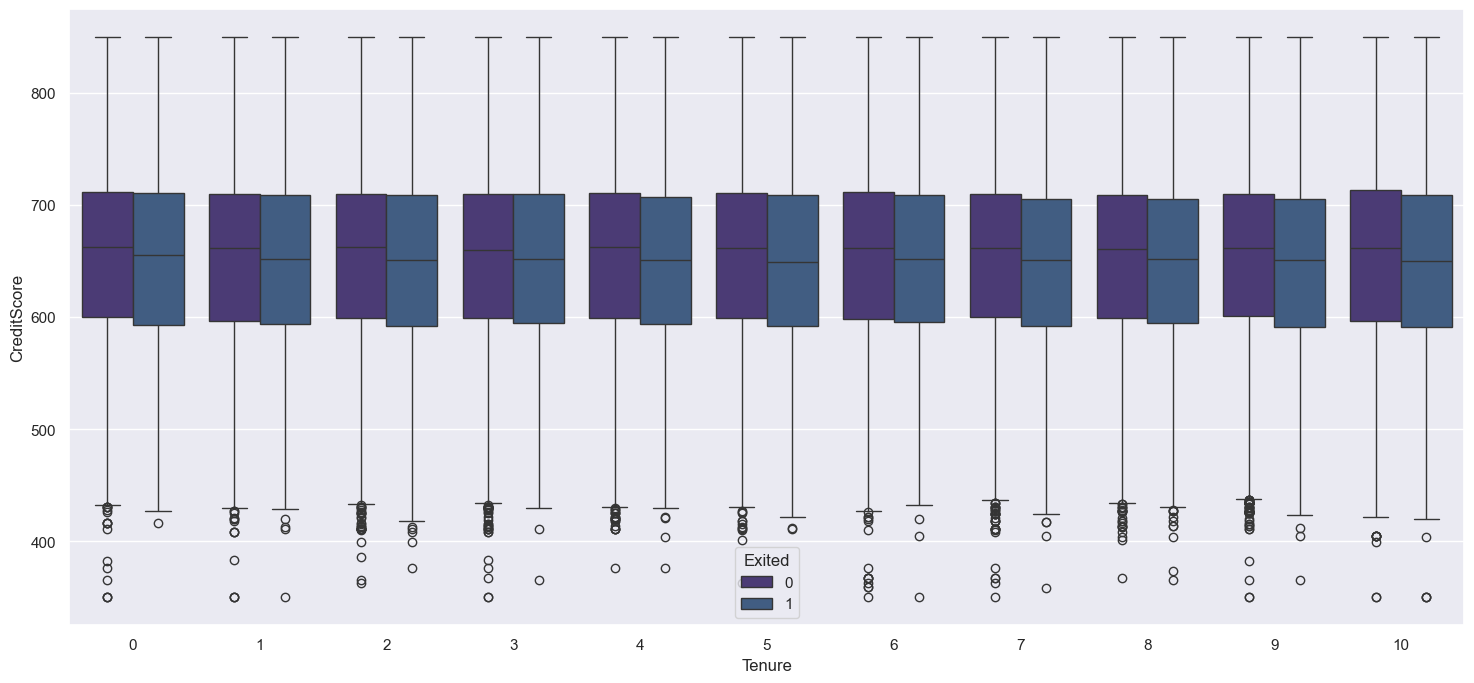

In [21]:
sns.boxplot(data=train,x='Tenure',y='CreditScore',hue='Exited')

According To The Tenure, The IQR Seems The Same. But There Is Some Outliers In The Non Churned Customers CreditScores In Each Tenure, Which Indicate That Even If The CreditScore Is Too Low Regardless The Tenure, It Has Low Probability To Churn

Balance Feature Has Interesting Insights, So We Let It To The End.

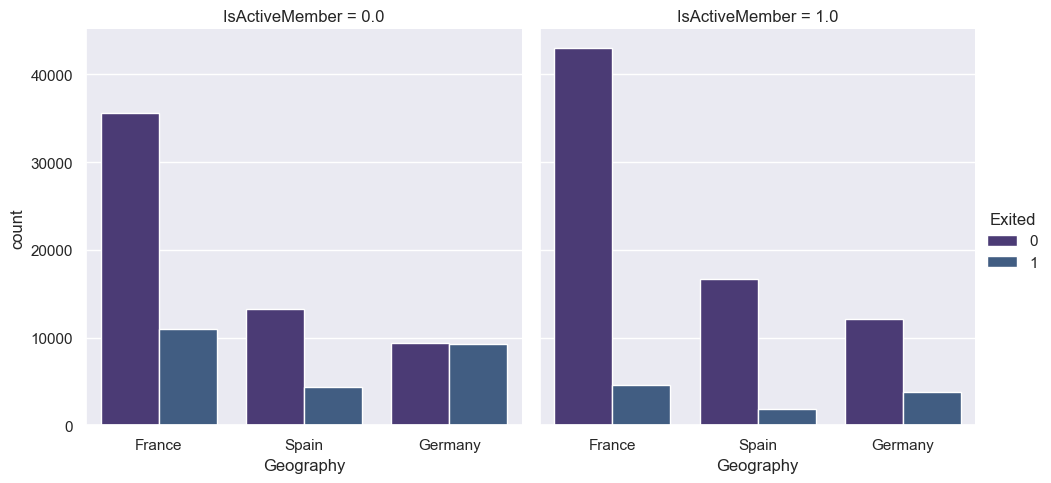

In [22]:
sns.catplot(data=train,x='Geography',hue='Exited',col='IsActiveMember',kind='count')

In Germany We Discovered That Non Active Customers Are More Likely To Churn Compared To Non Churned Customer Other Than Any Country.

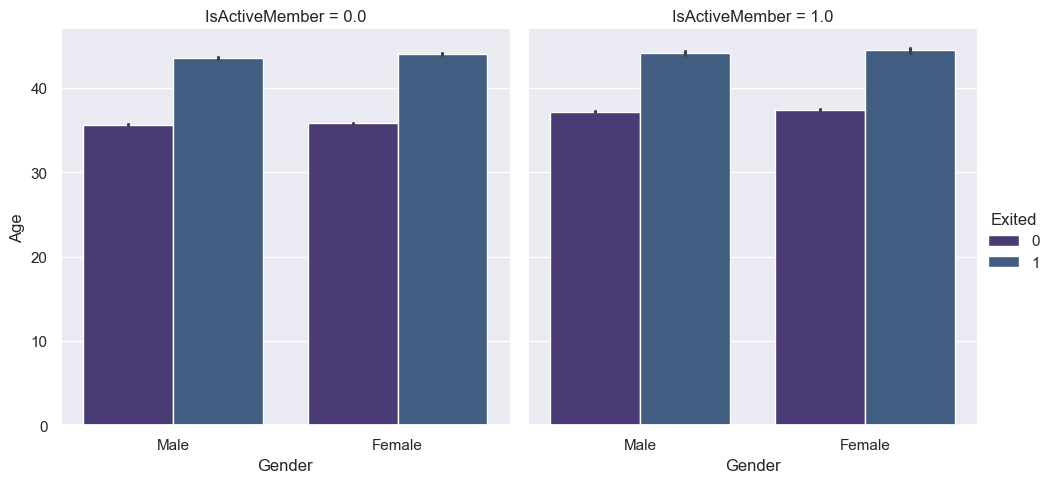

In [23]:
sns.catplot(data=train,x='Gender',y='Age',hue='Exited',kind='bar',col='IsActiveMember')

Regardless The Gender, Customers After Age 35 Are More Likely To Churn Even If There Are Active Members Or Not

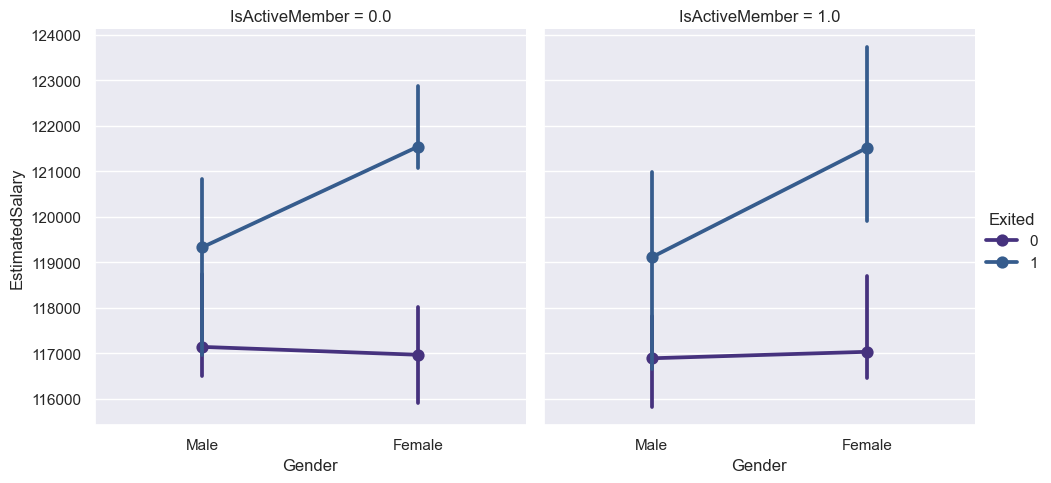

In [24]:
sns.catplot(data=train,x='Gender',y='EstimatedSalary',hue='Exited',kind='point',col='IsActiveMember',
           estimator=np.median)

it's Obvious Now That The Estimated Salary For Churned Customers Are More Specifically For Females, Regardless That They Are Active Members Or Not, Churned Females Always Have An Estimated Salary More Than Males.

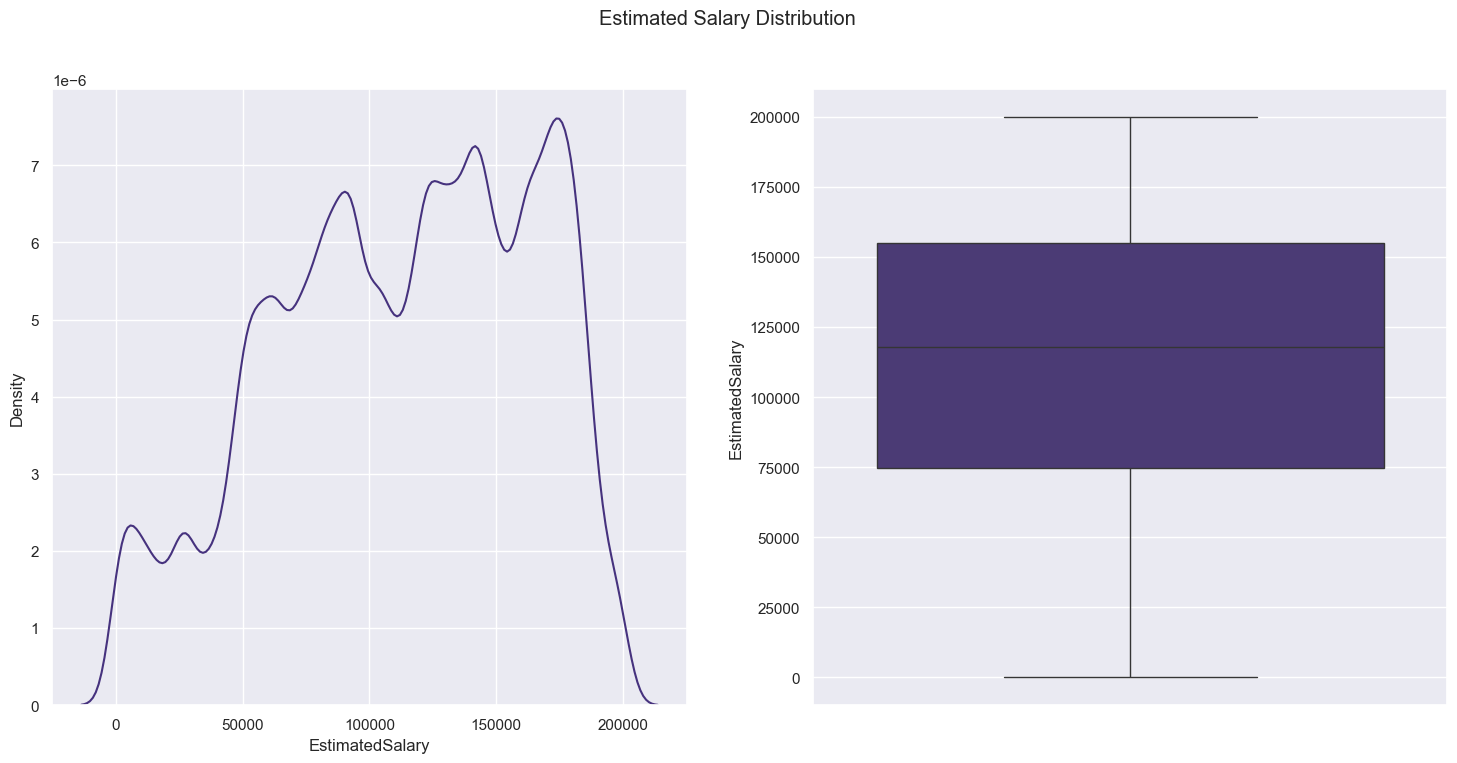

In [25]:
plt.subplot(121)
sns.kdeplot(train['EstimatedSalary'])
plt.subplot(122)
sns.boxplot(train['EstimatedSalary'])
plt.suptitle('Estimated Salary Distribution')
plt.show()

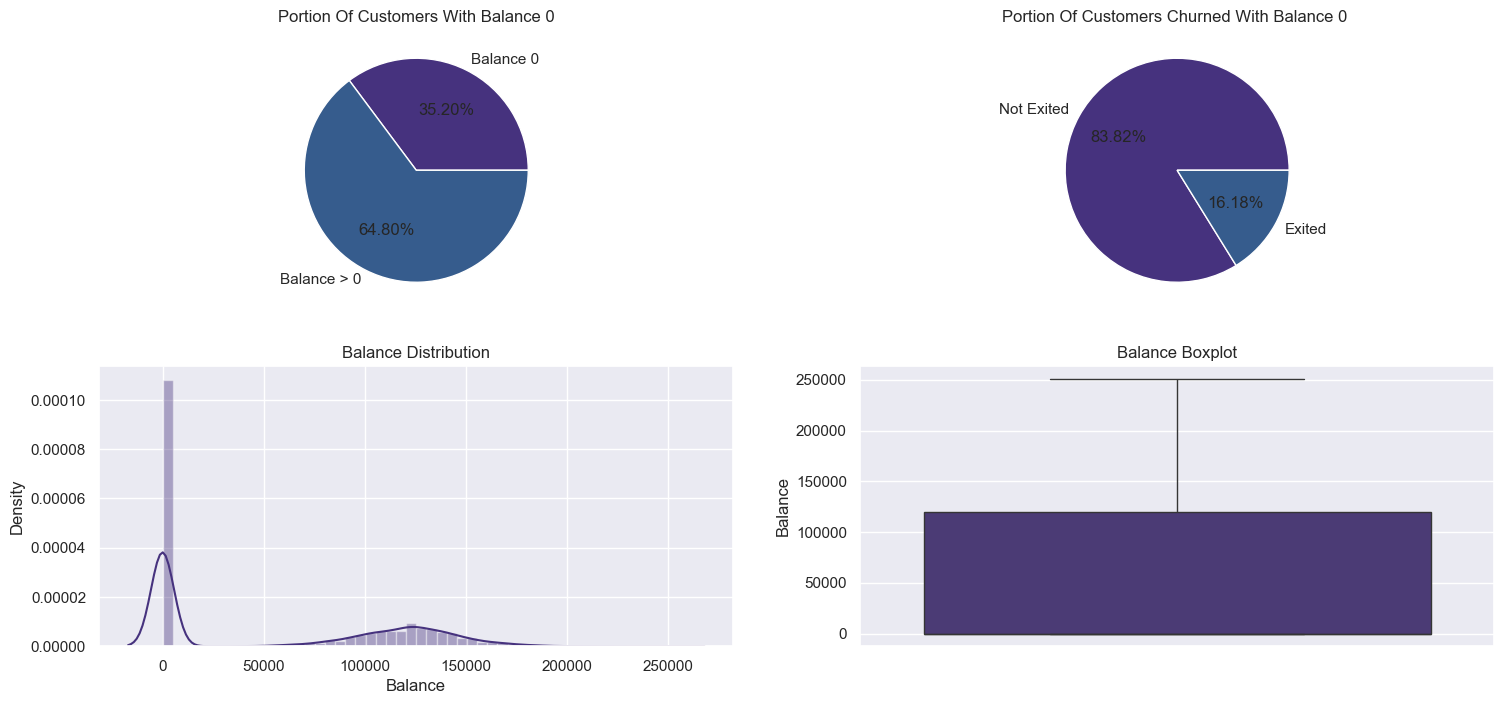

In [26]:
#Balance Feature
balance_0 = train[train['Balance']==0]
fig ,axs = plt.subplots(2,2)
#Plot-1
axs[0,0].set_title('Portion Of Customers With Balance 0')
axs[0,0].pie([len(balance_0),len(train)],labels=['Balance 0','Balance > 0'],
            autopct='%.2f%%')
#Plot-2
axs[0,1].set_title('Portion Of Customers Churned With Balance 0 ')
axs[0,1].pie(train[train['Balance']==0]['Exited'].value_counts(),autopct='%.2f%%',
             labels=['Not Exited','Exited'])
#Plot-3
sns.distplot(train['Balance'],ax=axs[1,0])
axs[1,0].set_title('Balance Distribution')
#Plot-4
sns.boxplot(train['Balance'],ax=axs[1,1])
axs[1,1].set_title('Balance Boxplot')
fig.show()

<Axes: xlabel='NumOfProducts', ylabel='Balance'>

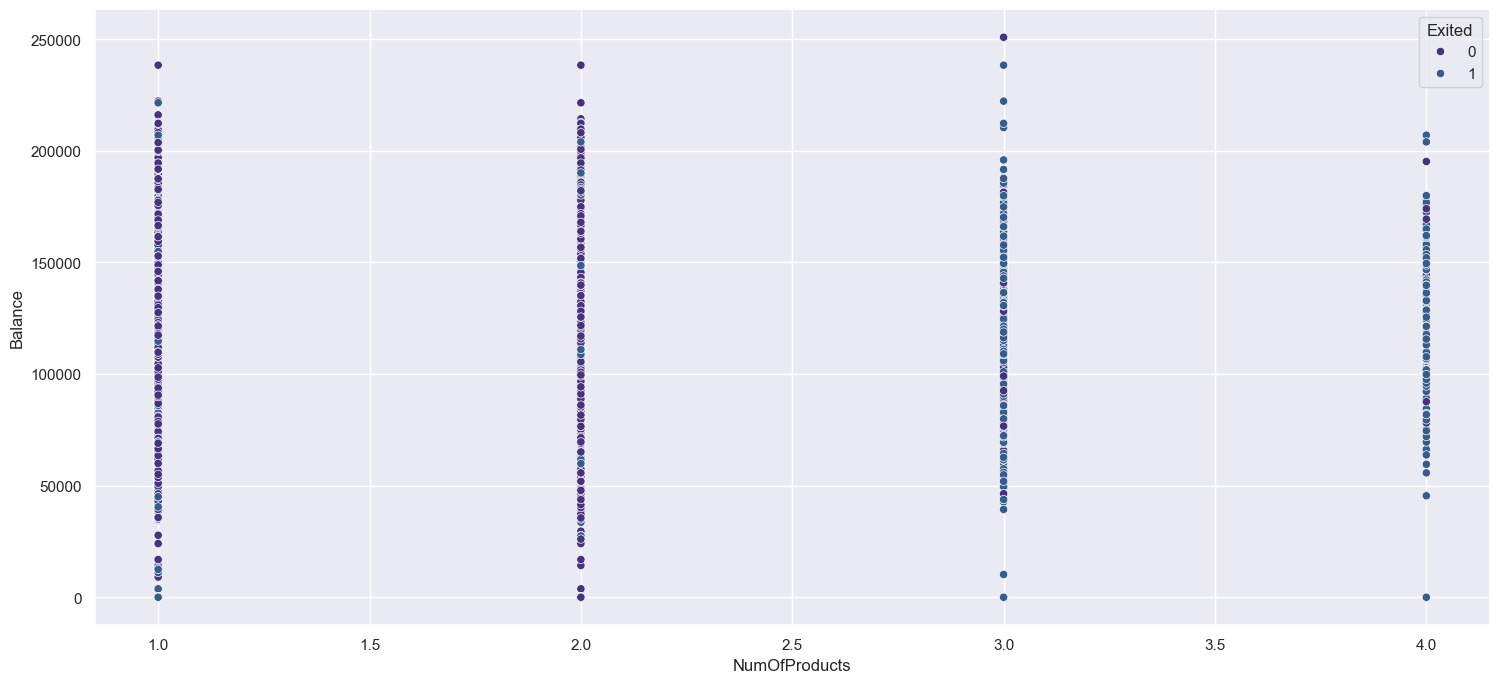

In [27]:
sns.scatterplot(data=train,x='NumOfProducts',y='Balance',hue='Exited')

# Model Building
Comparing 3 Models (Logistic Regression | Random Forest | XGBOOST),
We are interested in 'Recall', Since in the ground truth if the customer churned does the model predict that right? Also precision is important also and looking for a good precision score, but we does not interested more if the model predicted that customer will churn and he actually in the ground truth is not. Since we can make a + effort and this will enhance customer services even if the customer will not churn actually. Note that accuracy_score & f1_score can be misleading since the data is highly imbalanced.
- False Positive : The Model Predicts That Customer Will Churn But Ground Truth He Will Not.
- False Negative : The Model Predicts That Customer Will NOT Churn But Ground Truth He WILL. (IMP)

In [29]:
x = train.drop('Exited',axis=1)
y = train['Exited']

In [30]:
def train_preprocess(df):
    #Credit Score
    df['CreditScore'] = df['CreditScore'].\
    apply(lambda x : 0 if x<600 else (1 if x>=600 and x<=700 else 2))
    #Balance
    df['Balance'] = df['Balance'].\
    apply(lambda x : 0 if x<75000 else (1 if x>=75000 and x<=150000 else 2))
    #EstimatedSalary
    df['EstimatedSalary'] = df['EstimatedSalary'].\
    apply(lambda x : 0 if x<50000 else (1 if x>=50000 and x<=150000 else 2))
    #One-Hot-Encoding
    df = pd.get_dummies(df,columns=['Geography','Gender'],
                               drop_first=True)
    return df
x = train_preprocess(x)

In [31]:
#Stratified K-Fold
skf = StratifiedKFold(n_splits=5,random_state=10,shuffle=True)

In [32]:
#Preparing Models & Params To RandomSearchCV
models_params = {
    #LogisticRegression
    'LogisticRegression':[LogisticRegression(class_weight={0:0.21,1:0.79},n_jobs=-1),{
    'model__solver' : ['lbfgs','newton-cholesky','sag'],
    'model__C' : [0.01,1,10,100],
    'model__class_weight' : [None,{0:0.21,1:0.79}]}],#Classes distribution
    #RandomForest
    'RandomForest':[RandomForestClassifier(class_weight={0:0.21,1:0.79},n_jobs=-1),{
       'model__n_estimators' : [25,50,100],
        'model__criterion' : ['gini','log_loss'],
        'model__max_depth' : [20,40,60],
        'model__min_samples_split' : [20,40,60],
        'model__min_samples_leaf' : [10,20,30],
    'model__class_weight' : [None,{0:0.21,1:0.79}]}],
    #XGBOOST
    'XGBoost':[XGBClassifier(objective='binary:logistic',
                             colsample_bytree=0.8,n_jobs=-1),{
        'model__learning_rate': [0.1,0.3,0.5],
        'model__gamma' : [0,4,8],
        'model__n_estimators' : [25,50,100],
        'model__max_depth' : [20,40,60,100],
        'model__min_child_leaf' : [10,20,30,50],
        'model__reg_lambda' : [1,5,10],
        'model__scale_pos_weight' : [None,3.7] }] #len(class 0)/len(class 1)
}

In [33]:
#Evaluation Recall&Precision
scaler = MinMaxScaler()
best_models = {}
for model_name, modelAndparam in models_params.items():
    print('Model Name:',model_name)
    print('*'*30)
    model = modelAndparam[0]
    param_grid = modelAndparam[1]
    pipeline = Pipeline([
        ('scaler',MinMaxScaler()),
        ('model',model)
    ])
    RS = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        scoring=['precision','recall'],
        refit='recall',
        cv=skf,
        return_train_score=True,
        n_iter=15,
        n_jobs=-1
    )
    start = time()
    RS.fit(x,y)
    end = time()
    model_fitted = RS.best_estimator_
    best_param = RS.best_params_
    best_models[model_name] = [model_fitted,best_param]
    best_index = RS.best_index_
    
    print('Train Recall : ',round(RS.cv_results_['mean_train_recall'][best_index],2),\
         'Train Precision : ',round(RS.cv_results_['mean_train_precision'][best_index],2))
    print('Validation Recall : ',round(RS.cv_results_['mean_test_recall'][best_index],2),\
         'Validation Precision : ',round(RS.cv_results_['mean_test_precision'][best_index],2))
    
    #Time
    print('Running Time : ',round((end-start)/60.0,2),'Mins')
    print('*'*30)

Model Name: LogisticRegression
******************************
Train Recall :  0.74 Train Precision :  0.45
Validation Recall :  0.74 Validation Precision :  0.45
Running Time :  0.66 Mins
******************************
Model Name: RandomForest
******************************
Train Recall :  0.81 Train Precision :  0.55
Validation Recall :  0.79 Validation Precision :  0.54
Running Time :  5.99 Mins
******************************
Model Name: XGBoost
******************************
Train Recall :  0.8 Train Precision :  0.54
Validation Recall :  0.79 Validation Precision :  0.54
Running Time :  2.57 Mins
******************************


### Evaluate Precision Recall Curve On Models With Best Params

In [34]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,shuffle=True,
                                                 random_state=10,stratify=y)

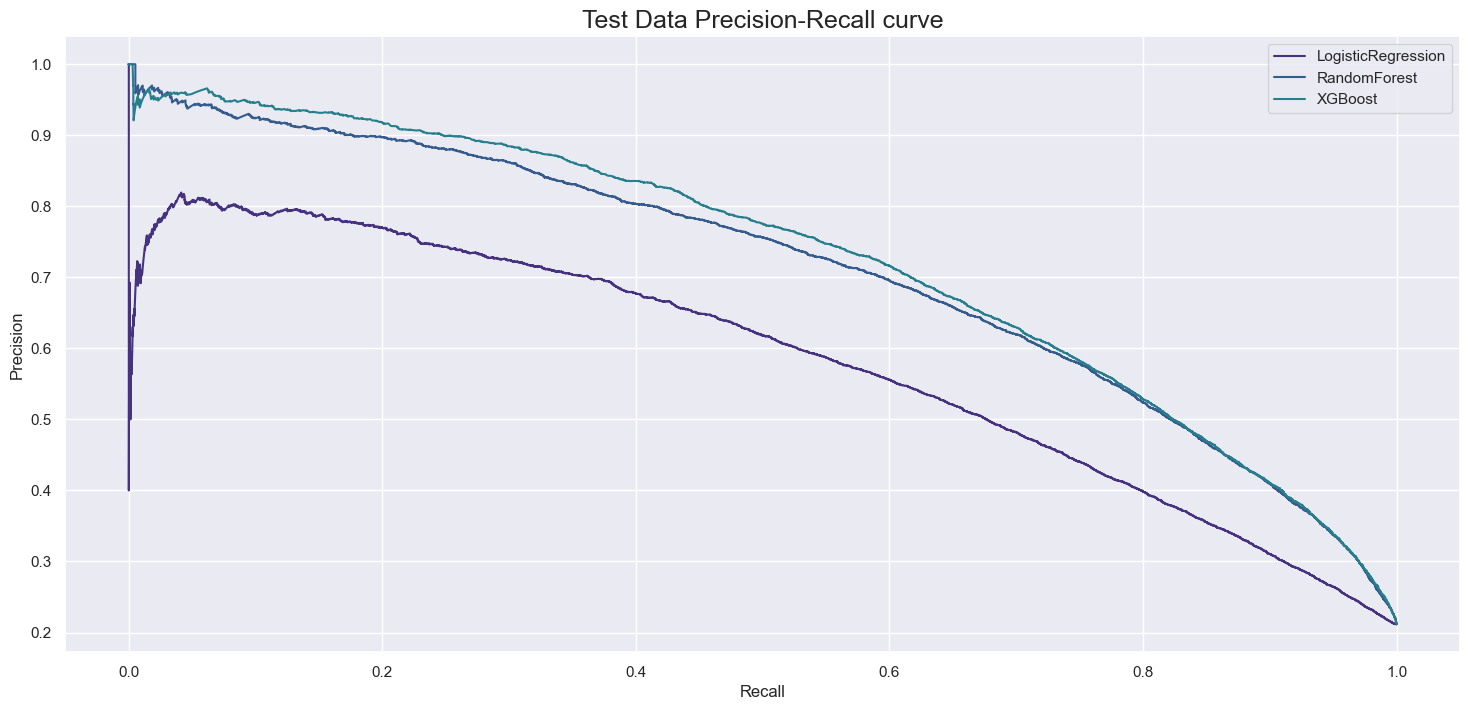

In [35]:
#Recall_Precision Curve
for name,model_ in best_models.items():
    model = model_[0]
    model.fit(x_train,y_train)
    y_proba = model.predict_proba(x_test)[:,1]
    precision,recall,_ = precision_recall_curve(y_test,y_proba)
    plt.plot(recall,precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Test Data Precision-Recall curve",size=18)
plt.legend(labels=list(best_models.keys()))
plt.grid(True)
plt.show()

- Logistic Regression Preforms Poorly Than Random Forest And XGBoost. XGBoost Seems To Be Preform Better Than Logisitc Regression And Slightly Better Than Random Forest On Unseen Data And Makes A Good Trade-off Between Recall & Precision. So We Will Consider It As Our Final Model

### Generalize The Pipeline And Save Model

In [36]:
#For Handling Test Data
def test_preprocess(data):
    #Droping Nulls if exist
    data = data.dropna()
    #Droping Duplicates if exist
    data = data.drop_duplicates()
    #ids
    customers_ids = data['id']
    #Drop unnecessary columns
    data = data.drop(columns=['id','CustomerId','Surname'])
    #Credit Score
    data['CreditScore'] = data['CreditScore'].\
    apply(lambda x : 0 if x<600 else (1 if x>=600 and x<=700 else 2))
    #Balance
    data['Balance'] = data['Balance'].\
    apply(lambda x : 0 if x<75000 else (1 if x>=75000 and x<=150000 else 2))
    #EstimatedSalary
    data['EstimatedSalary'] = data['EstimatedSalary'].\
    apply(lambda x : 0 if x<50000 else (1 if x>=50000 and x<=150000 else 2))
    #One-Hot-Encoding
    data = pd.get_dummies(data,columns=['Geography','Gender'],
                               drop_first=True)
    return data.reset_index(drop=True), customers_ids

In [37]:
#Model File
model = best_models['XGBoost'][0] #Pipeline model scaler+predictor
model.fit(x,y)
joblib.dump(model,'model.pkl')

['model.pkl']

Fitted pipeline retains the state it had when it was saved. In this case, the scaler within the pipeline has already been fitted to the training data, and the model has been trained on the scaled training data so by calling the pipeline it will transform and predict.

# Final Predictions

In [38]:
test_data = pd.read_csv("Data/test.csv")
test_data,customers_ids = test_preprocess(test_data)
model = joblib.load('model.pkl')
y_prob = model.predict_proba(test_data)[:,1]
final_df = pd.concat([customers_ids,pd.Series(np.round(y_prob,2))],axis=1).rename(
    columns={'id':'Customer_ID',0:'Churn_Probability'}
)
final_df.head()

,Customer_ID,Churn_Probability
0,165034,0.12
1,165035,0.94
2,165036,0.09
3,165037,0.52
4,165038,0.66


In [39]:
# Urgent Customers To Catch
final_df.sort_values(by='Churn_Probability',ascending=False).head(5)

,Customer_ID,Churn_Probability
105705,270739,0.99
50541,215575,0.99
49389,214423,0.99
2820,167854,0.99
57322,222356,0.99
